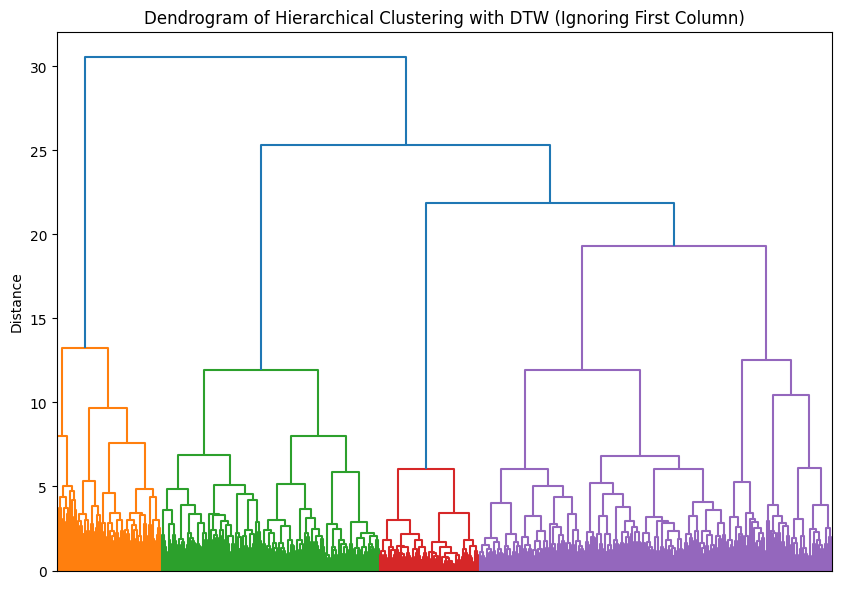

For n_clusters = 2, the Silhouette score is 0.2802
For n_clusters = 3, the Silhouette score is 0.1358
For n_clusters = 4, the Silhouette score is 0.1060
For n_clusters = 5, the Silhouette score is 0.1245
For n_clusters = 6, the Silhouette score is 0.1257
For n_clusters = 7, the Silhouette score is 0.1239
For n_clusters = 8, the Silhouette score is 0.1146
For n_clusters = 9, the Silhouette score is 0.0944

Optimal number of clusters: 2 with a Silhouette score of 0.2802
580 670


In [2]:
import pandas as pd
import numpy as np
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

shorest_traj = 9

file_path = '/Users/yangfanzhou/Desktop/1.8/Cluster_Data_1.86_withposition(cleaned).xlsx'  
df = pd.read_excel(file_path)


# Record the raw data
ID = df.iloc[0]['ID']
trajectory = 1
original_series = []
traj = []

for i in range(df.shape[0]):
    if df.iloc[i]['ID'] != ID and traj:
        if len(traj) >= shorest_traj:
            original_series.append(traj)
        ID = df.iloc[i]['ID']
        traj = []
    else:
        if df.iloc[i]['Label'] != trajectory and traj:
            if len(traj) >= shorest_traj:
                original_series.append(traj)
            trajectory = df.iloc[i]['Label']
            traj = []
    traj.append([df.iloc[i]['SpeedChange'], df.iloc[i]['AngleChange'], df.iloc[i]['Speed']])
original_series.append(traj)

df.pop('Speed')

# Normalization

df['SpeedChange'] = 2 * (df['SpeedChange'] - df['SpeedChange'].min()) / (df['SpeedChange'].max() - df['SpeedChange'].min()) - 1
df['AngleChange'] = 2 * (df['AngleChange'] - df['AngleChange'].min()) / (df['AngleChange'].max() - df['AngleChange'].min()) - 1

# Cluster based on normalized data
ID = df.iloc[0]['ID']
trajectory = 1
series = []
traj = []
for i in range(df.shape[0]):
    if df.iloc[i]['ID'] != ID and traj:
        if len(traj) >= shorest_traj + 1:
            series.append(traj)
        ID = df.iloc[i]['ID']
        traj = []
    else:
        if df.iloc[i]['Label'] != trajectory and traj:
            if len(traj) >= shorest_traj + 1:
                series.append(traj)
            trajectory = df.iloc[i]['Label']
            traj = []
    if not traj:
        traj.append([ID, trajectory])
    traj.append([df.iloc[i]['SpeedChange'], df.iloc[i]['AngleChange']])
series.append(traj)

time_series_data = [np.array(ts) for ts in series]

first_columns = [ts[0] for ts in time_series_data]  # Store the first column
processed_series = [ts[1:] for ts in time_series_data]
# print(processed_series[879])

# Step 2: Compute the pairwise DTW distance matrix using only the second column
n = len(processed_series)
dtw_distances = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        distance = dtw(processed_series[i], processed_series[j])
        dtw_distances[i, j] = distance
        dtw_distances[j, i] = distance

# Convert the distance matrix to a condensed distance matrix format
dtw_distances_condensed = squareform(dtw_distances)

# Step 3: Perform hierarchical clustering using the precomputed distance matrix
Z = linkage(dtw_distances_condensed, method='ward')

# Step 4: Optional: Visualize the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, no_labels=True)
plt.title("Dendrogram of Hierarchical Clustering with DTW (Ignoring First Column)")
plt.ylabel("Distance")
plt.savefig('Dendrogram.png')
plt.show()

# Step 5: Determine the optimal number of clusters using the Silhouette score
range_n_clusters = range(2, 10)  # Example range to check
best_n_clusters = None
best_silhouette_score = -1

for n_clusters in range_n_clusters:
    cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(dtw_distances, cluster_labels, metric='precomputed')
    print(f"For n_clusters = {n_clusters}, the Silhouette score is {silhouette_avg:.4f}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"\nOptimal number of clusters: {best_n_clusters} with a Silhouette score of {best_silhouette_score:.4f}")

# Step 6: Use the optimal number of clusters to finalize clustering
cluster_labels = fcluster(Z, t= best_n_clusters, criterion='maxclust')

# Step 7: Concatenate the first column back to the clustered data

clustered_dataset = []

for i in range(n):
    length = len(original_series[i])
    clustered_data = pd.DataFrame({
        'ID':[first_columns[i][0]] * length,
        'Label':[first_columns[i][1]] * length,
        'SpeedChange':[change[0] for change in original_series[i]],
        'AngleChange':[change[1] for change in original_series[i]],
        'Speed':[change[2] for change in original_series[i]],
        'Cluster':[cluster_labels[i]] * length
    })
    clustered_dataset.append(clustered_data)

clustered_dataset = pd.concat(clustered_dataset, ignore_index=True)

clustered_dataset.to_csv('/Users/yangfanzhou/Desktop/1.8/ClusterResult/cluster_result_hierarchy.csv', index = False)

cluster_2 = 0
for i in range(len(cluster_labels)):
    if cluster_labels[i] == 2:
        cluster_2+=1
print(cluster_2, len(cluster_labels))


In [3]:
data = pd.read_csv('/Users/yangfanzhou/Desktop/1.8/ClusterResult/cluster_result_hierarchy.csv')

# Group by Cluster, ID, and Label, then count the number of unique (ID, Label) pairs in each Cluster
cluster_participant_trajectory_counts = (
    data.groupby('Cluster')
    .apply(lambda x: x.groupby(['ID', 'Label']).ngroups)
    .reset_index(name='Unique Trajectory Count')
)

# Display the result
print(cluster_participant_trajectory_counts)


   Cluster  唯一轨迹数量
0        1      88
1        2     566


/var/folders/8t/9k64w8hn15ng50h2zwfs07tr0000gn/T/ipykernel_52679/751746262.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.groupby(['ID', 'Label']).ngroups)


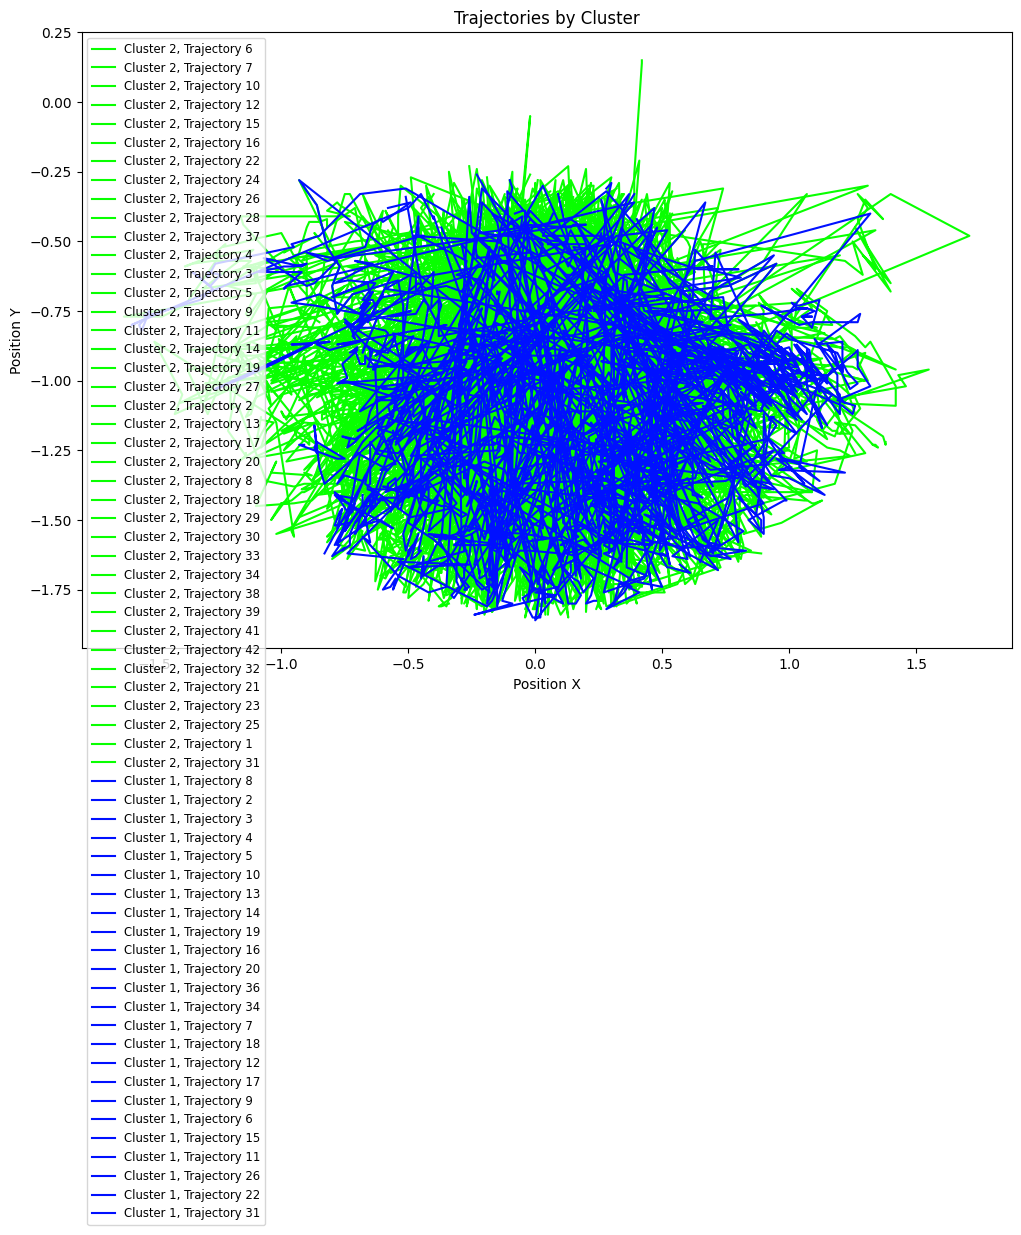

In [4]:
# Load the original dataset, which contains the Positionx and Positiony columns
original_df = pd.read_excel('/Users/yangfanzhou/Desktop/1.8/Cluster_Data_1.86_withposition(cleaned).xlsx')  # If reading from a file is needed

# Merge the clustering results with the original data
merged_df = pd.merge(df, clustered_dataset[['ID', 'Label', 'Cluster']], on=['ID', 'Label'])

# Get all unique cluster labels
unique_clusters = merged_df['Cluster'].unique()

# Use seaborn's color palette to define colors and generate enough colors
palette = sns.color_palette("hsv", len(unique_clusters))

# Create a mapping of cluster numbers to colors
cluster_color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each trajectory
for cluster in unique_clusters:
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    
    for label in cluster_data['Label'].unique():
        trajectory_data = cluster_data[cluster_data['Label'] == label]
        plt.plot(trajectory_data['Positionx'], trajectory_data['Positiony'], 
                 label=f'Cluster {cluster}, Trajectory {label}', 
                 color=cluster_color_map[cluster])

# Add legend
plt.legend(loc='best', fontsize='small')

# Set plot title and axis labels
plt.title('Trajectories by Cluster')
plt.xlabel('Position X')
plt.ylabel('Position Y')

# Show plot
plt.show()


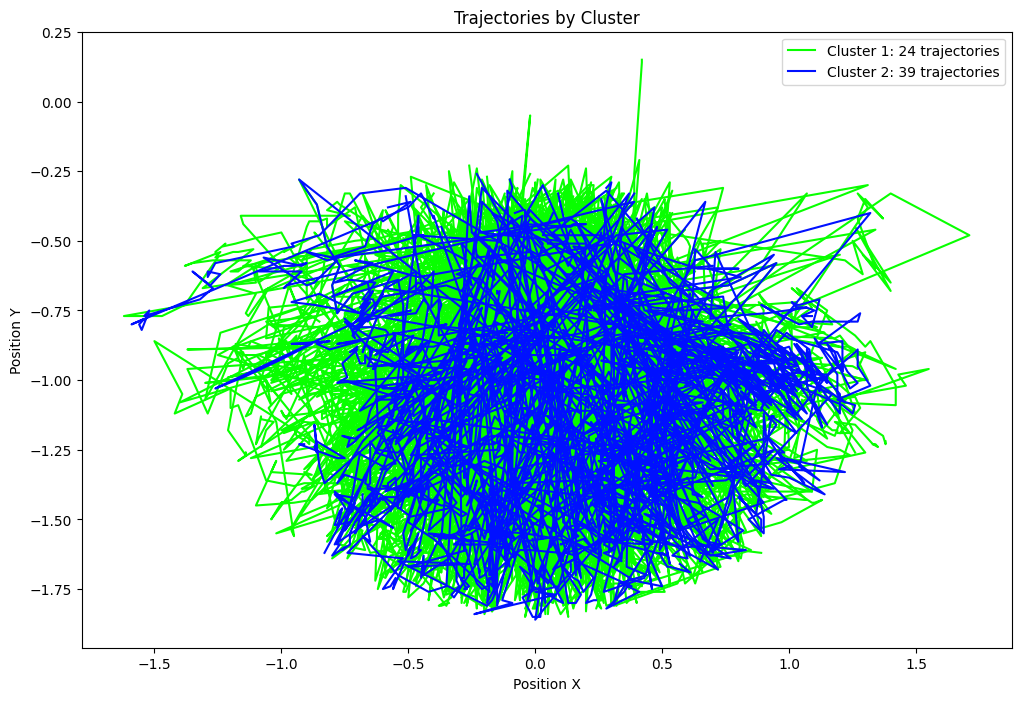

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original dataset, which contains the Positionx and Positiony columns
original_df = pd.read_excel('/Users/yangfanzhou/Desktop/1.8/Cluster_Data_1.86_withposition(cleaned).xlsx')  # If reading from a file is needed

# Merge the clustering results with the original data
merged_df = pd.merge(df, clustered_dataset[['ID', 'Label', 'Cluster']], on=['ID', 'Label'])

# Get all unique cluster labels
unique_clusters = merged_df['Cluster'].unique()

# Use seaborn's color palette to define colors and generate enough colors
palette = sns.color_palette("hsv", len(unique_clusters))

# Create a mapping of cluster numbers to colors
cluster_color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each trajectory
for cluster in unique_clusters:
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    
    for label in cluster_data['Label'].unique():
        trajectory_data = cluster_data[cluster_data['Label'] == label]
        plt.plot(trajectory_data['Positionx'], trajectory_data['Positiony'], 
                 color=cluster_color_map[cluster])

# Calculate the number of trajectories for each cluster
cluster_trajectory_count = merged_df.groupby('Cluster')['Label'].nunique()

# Create a simplified legend showing cluster number and trajectory count
legend_labels = [f'Cluster {cluster}: {count} trajectories' for cluster, count in cluster_trajectory_count.items()]
for cluster, label in zip(unique_clusters, legend_labels):
    plt.plot([], [], color=cluster_color_map[cluster], label=label)

# Add legend
plt.legend(loc='best', fontsize='medium')

# Set plot title and axis labels
plt.title('Trajectories by Cluster')
plt.xlabel('Position X')
plt.ylabel('Position Y')

# Show plot
plt.show()


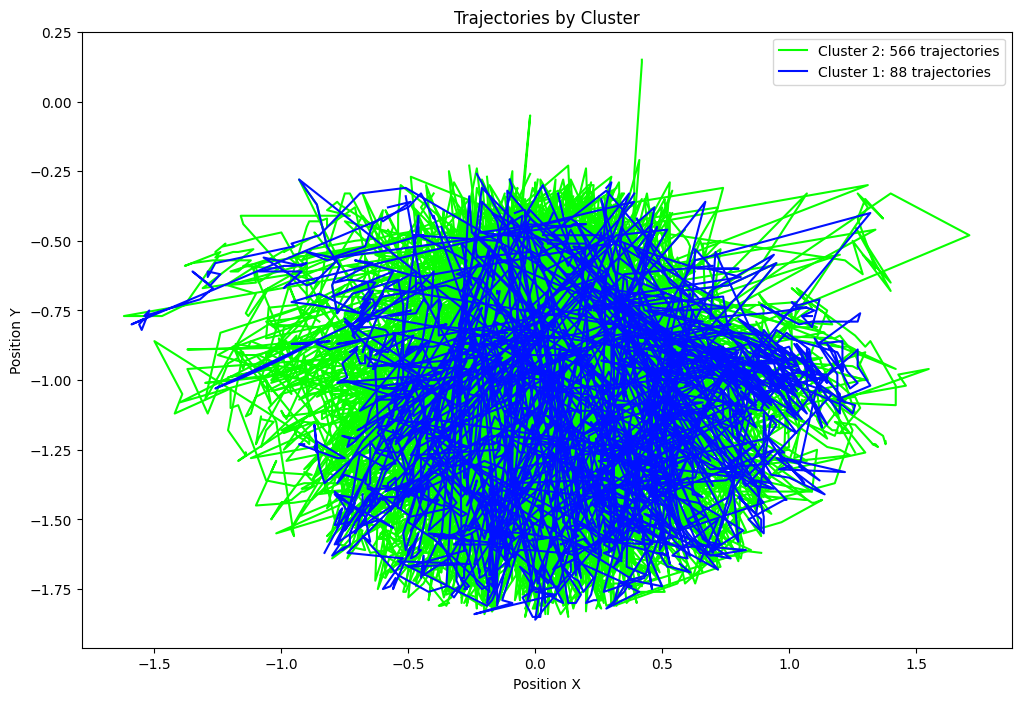

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original dataset, which contains the Positionx and Positiony columns
original_df = pd.read_excel('/Users/yangfanzhou/Desktop/1.8/Cluster_Data_1.86_withposition(cleaned).xlsx')  # If reading from a file is needed

# Merge the clustering results with the original data
merged_df = pd.merge(df, clustered_dataset[['ID', 'Label', 'Cluster']], on=['ID', 'Label'])

# Get all unique cluster labels
unique_clusters = merged_df['Cluster'].unique()

# Use seaborn's color palette to define colors and generate enough colors
palette = sns.color_palette("hsv", len(unique_clusters))

# Create a mapping of cluster numbers to colors
cluster_color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each trajectory
for cluster in unique_clusters:
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    
    for label in cluster_data['Label'].unique():
        trajectory_data = cluster_data[cluster_data['Label'] == label]
        plt.plot(trajectory_data['Positionx'], trajectory_data['Positiony'], 
                 color=cluster_color_map[cluster])

# Manually specify the number of trajectories for each cluster
manual_legend_labels = {
    1: 88,  # Cluster 1 has x trajectories
    2: 566  # Cluster 2 has y trajectories
}

# Create a custom legend
legend_labels = [f'Cluster {cluster}: {manual_legend_labels[cluster]} trajectories' for cluster in unique_clusters]
for cluster, label in zip(unique_clusters, legend_labels):
    plt.plot([], [], color=cluster_color_map[cluster], label=label)

# Add legend
plt.legend(loc='best', fontsize='medium')

# Set plot title and axis labels
plt.title('Trajectories by Cluster')
plt.xlabel('Position X')
plt.ylabel('Position Y')

# Show plot
plt.show()
